In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, LSTM, Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Load Data
df = pd.read_excel("rumah_tangga.xlsx")

In [5]:
# Menampilkan 5 data teratas
df.head()

,No,Daerah,Kelompok Umur,Tahun,Belum Kawin,Kawin,Cerai Hidup,Cerai Mati,Jenis Kelamin
0,1,Perkotaan,10-24,2009,91.63,4.11,3.30,0.97,Perempuan
1,2,Perkotaan,25-44,2009,21.24,20.57,30.22,27.97,Perempuan
2,3,Perkotaan,45-59,2009,3.23,6.52,17.38,72.88,Perempuan
3,4,Perkotaan,60+,2009,1.35,2.08,5.04,91.52,Perempuan
4,5,Pedesaan,10-24,2009,42.37,37.71,15.46,4.46,Perempuan


In [6]:
# Menampilkan info kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             368 non-null    int64  
 1   Daerah         368 non-null    object 
 2   Kelompok Umur  368 non-null    object 
 3   Tahun          368 non-null    int64  
 4   Belum Kawin    368 non-null    float64
 5   Kawin          368 non-null    float64
 6   Cerai Hidup    368 non-null    float64
 7   Cerai Mati     368 non-null    float64
 8   Jenis Kelamin  368 non-null    object 
dtypes: float64(4), int64(2), object(3)
memory usage: 26.0+ KB


In [8]:
# Mengecek missing value
df.isnull().sum()

No               0
Daerah           0
Kelompok Umur    0
Tahun            0
Belum Kawin      0
Kawin            0
Cerai Hidup      0
Cerai Mati       0
Jenis Kelamin    0
dtype: int64

In [7]:
# Menghapus baris yang memiliki missing values
df.dropna(inplace=True)

In [9]:
# Menyaring data hanya untuk jenis kelamin perempuan
df_perempuan = df[df['Jenis Kelamin'] == 'Perempuan'].copy()

In [10]:
# Menampilkan jumlah data setelah disaring
print("Jumlah data perempuan:", df_perempuan.shape)

Jumlah data perempuan: (176, 9)


In [11]:
# Mengecek kembali missing value setelah filter
df_perempuan.isnull().sum()

No               0
Daerah           0
Kelompok Umur    0
Tahun            0
Belum Kawin      0
Kawin            0
Cerai Hidup      0
Cerai Mati       0
Jenis Kelamin    0
dtype: int64

In [12]:
# Konversi kolom target menjadi numerik
target_cols = ['Belum Kawin', 'Kawin', 'Cerai Hidup', 'Cerai Mati']
for col in target_cols:
    df_perempuan[col] = pd.to_numeric(df_perempuan[col], errors='coerce')

In [13]:
# Mengecek kembali apakah ada nilai NaN setelah konversi
df_perempuan[target_cols].isnull().sum()


Belum Kawin    0
Kawin          0
Cerai Hidup    0
Cerai Mati     0
dtype: int64

In [14]:
# Melakukan one-hot encoding pada kolom kategori
df_perempuan = pd.get_dummies(df_perempuan, columns=['Daerah', 'Kelompok Umur'])

In [15]:
# Normalisasi nilai target
scaler = MinMaxScaler()
df_perempuan[target_cols] = scaler.fit_transform(df_perempuan[target_cols])

In [16]:
# Menampilkan data setelah diproses
df_perempuan.head()

,No,Tahun,Belum Kawin,Kawin,Cerai Hidup,Cerai Mati,Jenis Kelamin,Daerah_Pedesaan,Daerah_Perkotaan,Daerah_Perkotaan + Pedesaan,Kelompok Umur_10-24,Kelompok Umur_25-44,Kelompok Umur_45-59,Kelompok Umur_60+
0,1,2009,0.960174,0.052151,0.045193,0.010584,Perempuan,False,True,False,True,False,False,False
1,2,2009,0.214596,0.409822,0.748433,0.305183,Perempuan,False,True,False,False,True,False,False
2,3,2009,0.023832,0.104520,0.413009,0.795199,Perempuan,False,True,False,False,False,True,False
3,4,2009,0.003919,0.008040,0.090648,0.998582,Perempuan,False,True,False,False,False,False,True
4,5,2009,0.438407,0.782269,0.362853,0.048663,Perempuan,True,False,False,True,False,False,False


In [17]:
# Fungsi untuk membuat dataset time series
def create_dataset(data, time_steps=5):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [18]:
# Buat data time series
X, y = create_dataset(df[target_cols].values, time_steps=5)

In [20]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Bentuk input
print("Input shape:", X_train.shape)

Input shape: (290, 5, 4)


In [22]:
# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

In [25]:
# ===== 2. MODEL CNN (CONV1D) =====
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model_cnn.add(Dropout(0.3))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(y.shape[1]))
model_cnn.compile(optimizer='adam', loss='mse')
model_cnn.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stop], verbose=1)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 1347.0059 - val_loss: 376.1685
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 394.7459 - val_loss: 197.4587
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 263.8091 - val_loss: 158.6974
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 203.2072 - val_loss: 130.0044
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 179.7838 - val_loss: 113.7114
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 153.7713 - val_loss: 110.6852
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 187.3126 - val_loss: 97.7651
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 130.8496 - val_loss: 99.8299
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 143.0907 - val_loss: 93.7262
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - loss: 128.7222 - val_loss: 98.7385
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 136.7984 - val_loss: 87.3178
Epoch 12/50
15/15 

In [26]:
# ===== 3. MODEL LSTM =====
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dense(y.shape[1]))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stop], verbose=1)

c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - loss: 1698.6849 - val_loss: 1702.6638
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 1667.4200 - val_loss: 1619.2147
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 1582.4204 - val_loss: 1486.7314
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1433.7635 - val_loss: 1297.0906
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1252.0552 - val_loss: 1080.2855
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1041.2640 - val_loss: 880.6124
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 853.5617 - val_loss: 736.7181
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 711.6952 - val_loss: 614.0767
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 588.4977 - val_loss: 509.8616
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 494.5496 - val_loss: 425.9576
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 505.0595 - val_loss: 356.6407
Epoch

In [34]:
# 8. Buat model Deep Learning: Conv1D + LSTM
model = Sequential()
model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(y.shape[1]))
model.compile(optimizer='adam', loss='mse')


c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
# evaluasi setiap model
def evaluate_model(model, name):
    predicted = model.predict(X)

    rmse = np.sqrt(mean_squared_error(y, predicted))
    mae = mean_absolute_error(y, predicted)
    r2 = r2_score(y, predicted)

    print(f"\n[{name}]")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")
    return rmse, mae, r2

results = {}
results['CNN'] = evaluate_model(model_cnn, "CNN")
results['LSTM'] = evaluate_model(model_lstm, "LSTM")
results['CNN-LSTM'] = evaluate_model(model_cnn_lstm, "CNN-LSTM")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step


NameError: name 'mean_absolute_error' is not defined

In [30]:
# Hitung MSE dan tampilkan
for name, pred in preds.items():
    mse = mean_squared_error(y_test, pred)
    print(f"MSE {name}: {mse:.5f}")

MSE CNN: 65.85513
MSE LSTM: 57.53742
MSE CNN-LSTM: 827.11252


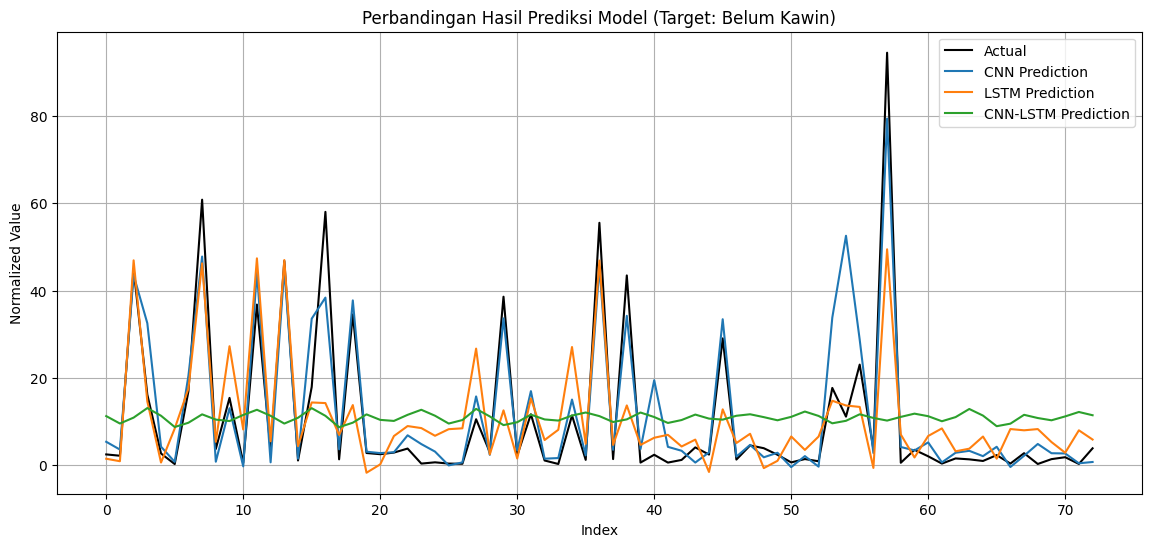

In [31]:
# ===== Visualisasi hasil prediksi target 'Belum Kawin' =====
plt.figure(figsize=(14, 6))
plt.plot(y_test[:, 0], label='Actual', color='black')
for name, pred in preds.items():
    plt.plot(pred[:, 0], label=f'{name} Prediction')
plt.title("Perbandingan Hasil Prediksi Model (Target: Belum Kawin)")
plt.xlabel("Index")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.show()